In [1]:
import os
import torch
from torch import nn
from poutyne import Model, CSVLogger
from poutyne.framework import ModelCheckpoint, EarlyStopping, plot_history
import numpy as np
import torchmetrics
from datetime import datetime
import sys
import pandas as pd
from custom_lib.custom_models.basic_nn import NeuralNetwork
from custom_lib.data_prep import data_transformation_pipeline, data_loader
import matplotlib as plt
import torchvision.models as models
import time


In [2]:
# Tuneable Params
lr = 1e-3
data_dir = "data_3_class"
model_name = "truncated_b0_leaky" 
image_size = 224
center_crop = 224
save_logs = True
epochs = 1
rotate_angle=None
horizontal_flip_prob=None
brightess_contrast=None
gaussian_blur=None
normalize=True
seed = 42
batch_size = 32
results_folder_name = "test"
truncated_layers = 0
bootstrap_n = None
pretrained = True
dropout_p = .2
train_prop = .8
val_prop = .1



In [3]:
torch.manual_seed(seed)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [5]:
train_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=True)
test_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)
val_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)


train_loader , val_loader, test_loader, num_classes = data_loader(data_dir, 
                                                     train_transform=train_transform,
                                                     test_transform=test_transform,
                                                     val_transform=val_transform,
                                                     seed=seed,
                                                     batch_size=batch_size,
                                                     train_prop=train_prop,
                                                     val_prop =val_prop
                                                     )


Train size: 4182, Validation size: 522, Test size: 524


In [6]:
from collections import Counter
from torchvision.datasets import ImageFolder

# Get class names
dataset = ImageFolder(data_dir)  # Load without transformations just to access class names
class_names = dataset.classes


def count_samples_per_class(dataset, class_names):
    """Counts the number of samples per class in a dataset split."""
    class_counts = Counter([dataset.dataset.samples[idx][1] for idx in dataset.indices])
    return {class_names[class_idx]: count for class_idx, count in class_counts.items()}

count_samples_per_class(test_loader.dataset, class_names)




{'COVID': 160, 'NORMAL': 182, 'PNEUMONIA': 182}

In [7]:
import importlib

def load_model(model_name, **kwargs):
    """Dynamically loads and instantiates a model from custom_lib.custom_models."""
    module = importlib.import_module(f"custom_lib.custom_models.{model_name}")
    
    # Find the first class in the module (assuming only one model class per file)
    model_class = getattr(module, model_name, None)
    
    if model_class is None:
        raise ValueError(f"Could not find a class named '{model_name}' in '{module.__name__}'")

    return model_class(**kwargs)


model = load_model(
    model_name,
    num_classes=num_classes,
    removed_layers=truncated_layers,
    batch_size=batch_size,
    image_size=image_size,
    pretrained=pretrained,
    dropout_p=dropout_p
)


In [8]:
if save_logs:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    # Create directory for saving all logs and model outputs 
    results_dir = os.path.join(f"{results_folder_name}/{model_name}_reduced_layers_{truncated_layers}_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)
    print(f"Logs and output will be saved in: {results_dir}")


Logs and output will be saved in: test/truncated_b0_leaky_reduced_layers_0_2025-03-01_14-05


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau




# 6. Wrap the model with Poutyne
poutyne_model = Model(
    model,
    # optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9),  # Added momentum

    optimizer=torch.optim.Adam(model.parameters(), lr=lr),
    loss_function=nn.CrossEntropyLoss(),
    batch_metrics=["accuracy"],
    device=device
)

In [10]:
from poutyne import ReduceLROnPlateau, Callback

# Add the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce LR by a factor of 0.1
    patience=5           # Wait 5 epochs before reducing LR

)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

class PrintLRSchedulerCallback(Callback):
    def set_model(self, model):
        self.model = model  # Store the model reference

    def on_epoch_end(self, epoch, logs):
        lr = self.model.optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}: Current LR = {lr}")

# Instantiate the callback
print_lr_callback = PrintLRSchedulerCallback()

# Add it to the list of callbacks
# callbacks = [reduce_lr, early_stopping, print_lr_callback]
callbacks = [reduce_lr, print_lr_callback]

if save_logs == True:
    # Callback: Save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(f"{results_dir}/best_model.pth", monitor='val_loss', mode='min', save_best_only=True)
    csv_logger = CSVLogger(f"{results_dir}/training_logs.csv")
    callbacks = [checkpoint, csv_logger, reduce_lr, print_lr_callback]
    

start_time = time.time()
# 7. Train the model
history = poutyne_model.fit_generator(train_loader, val_loader, epochs=epochs, verbose=True,
                            callbacks = callbacks)
end_time = time.time()

run_time = end_time - start_time

print(f"Model training took {run_time / 60} minutes")

if save_logs:
    # Save the final model manually
    torch.save(poutyne_model.network.state_dict(), f"{results_dir}/final_model.pth")

Epoch: 1/1 Train steps: 130 Val steps: 8 1m32.50s loss: 0.157170 acc: 95.024038 val_loss: 0.069437 val_acc: 97.851562
Epoch 2: Current LR = 0.001
Model training took 1.544122850894928 minutes


In [11]:
if save_logs:
    best_model_path = f"{results_dir}/best_model.pth"
    
    # Load the state dict into the model
    poutyne_model.network.load_state_dict(torch.load(best_model_path))


/var/folders/gw/q9_8w8jn0js6k5m5d98vhhcdzkx593/T/ipykernel_17684/2789483476.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  poutyne_model.network.load_state_dict(torch.l

In [12]:
from thop import profile

# Create a dummy input tensor with the same shape as your model's input
dummy_input = torch.randn(batch_size, 3, image_size, image_size).to(device)  # Batch size = 1, Channels = 3, Height = image_size, Width = image_size

# Compute FLOPs and parameters
flops, params = profile(model, inputs=(dummy_input,))

gflops = flops / 1000000000

print(f"GFLOPs: {gflops}")
print(f"Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
GFLOPs: 11.6295168
Parameters: 2903247.0


/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


((<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>),
 (<Axes: title={'center': 'truncated_b0_leaky Training'}, xlabel='Epochs', ylabel='Loss'>,
  <Axes: title={'center': 'truncated_b0_leaky Training'}, xlabel='Epochs', ylabel='Accuracy'>))

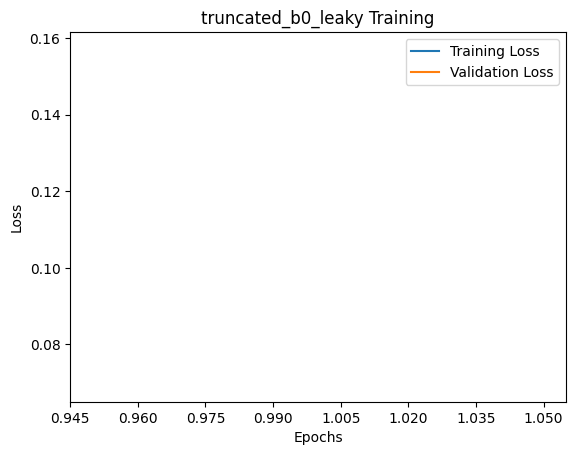

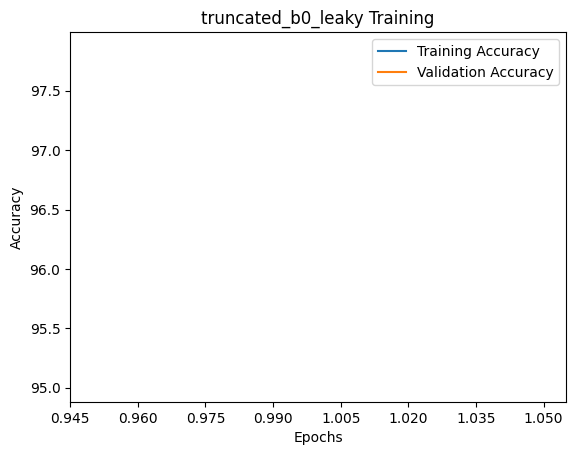

In [13]:
plot_history(
        history,
        metrics=['loss', 'acc'],
        labels=['Loss', 'Accuracy'],
        titles=f"{model_name} Training",

    )

In [14]:

if bootstrap_n == None:

    # Evaluate using Poutyne
    test_loss, test_acc = poutyne_model.evaluate_generator(test_loader)
else: 
    from custom_lib.bootstrap import bootstrap_evaluation_poutyne

    if save_logs:
        # Run bootstrapping evaluation with your Poutyne model
        boot_strap_results = bootstrap_evaluation_poutyne(poutyne_model, test_loader, n_bootstraps = bootstrap_n, save_logs=save_logs, results_dir=results_dir, seed=seed)
    else:
        boot_strap_results = bootstrap_evaluation_poutyne(poutyne_model, test_loader, n_bootstraps = bootstrap_n, save_logs=save_logs, seed=seed)


Test steps: 8 27.57s test_loss: 0.050757 test_acc: 98.632812                               


In [15]:
next(iter(train_loader))[0].device

device(type='cpu')

/var/folders/gw/q9_8w8jn0js6k5m5d98vhhcdzkx593/T/ipykernel_15257/2643475120.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results_df = pd.concat([test_results_df, new_results_df], ignore_index=True)
/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


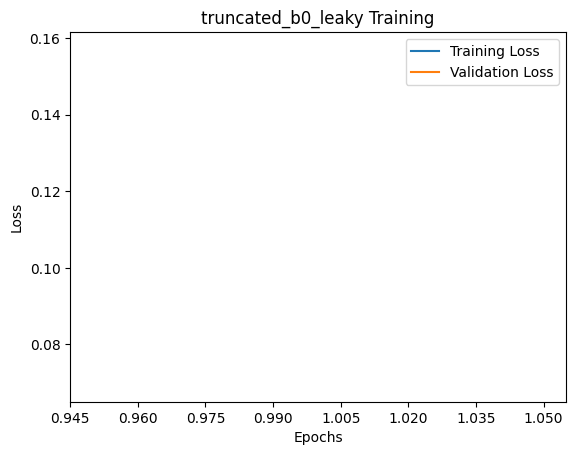

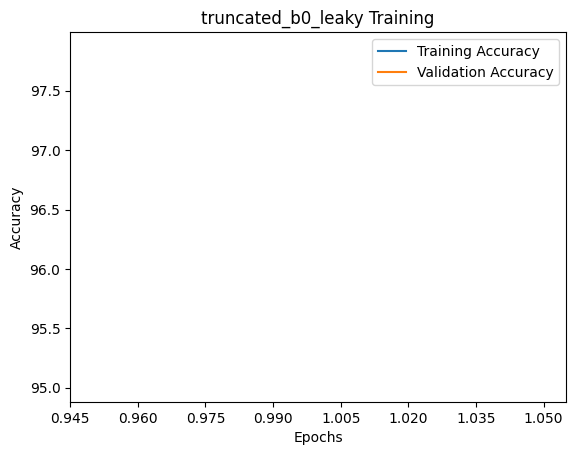

In [15]:
# Save logs and plots
if save_logs:
    with open(f"{results_dir}/model_overview.txt", "w") as file:
        file.write(f"Model Structure:\n{model}\n")
        file.write(f"Using {device} device\n")

# Check if CSV exists
    if os.path.exists(f"{results_folder_name}/test_results.csv"):
        test_results_df = pd.read_csv(f"{results_folder_name}/test_results.csv")
    else:
        test_results_df = pd.DataFrame(columns=[
            "model_id", "model", "epochs", "run_time", "lr", "image_size",
            "rotate_angle", "horizontal_flip_prob", "gaussian_blur", "normalize", "seed", "truncated_layers"
        ])

    if bootstrap_n != None:
        test_loss = None
        test_acc = None


    # Create a DataFrame for the new model's metadata
    new_results_df = pd.DataFrame({
        "model_id": [f"{model_name}_reduced_layers_{truncated_layers}_{timestamp}"],
        "model": [model_name],
        "truncated_layers": [truncated_layers],
        "epochs": [epochs],  
        "batch_size": [batch_size],
        "run_time": [run_time / 60],  
        "lr": [lr],
        "image_size": [image_size],  
        "rotate_angle": [rotate_angle],  
        "horizontal_flip_prob": [horizontal_flip_prob],  
        "gaussian_blur": [gaussian_blur],  
        "normalize": [normalize],
        "seed": [seed],
        "gflops": [gflops],
        "params": [params],
        "single_test_acc": [test_acc],
        "single_test_loss": [test_loss],
        "bootstrap_n": [bootstrap_n]
        })

    if bootstrap_n != None:
        # Combine test metadata with bootstrapped results (column-wise merge)
        new_results_df = pd.concat([new_results_df, boot_strap_results], axis=1)


    # Append to existing DataFrame
    test_results_df = pd.concat([test_results_df, new_results_df], ignore_index=True)

    # Save updated results
    test_results_df.to_csv(f"{results_folder_name}/test_results.csv", index=False)

    # Plot training history
    plot_history(
        history,
        metrics=['loss', 'acc'],
        labels=['Loss', 'Accuracy'],
        titles=f"{model_name} Training",
        save=True,  
        save_filename_template='{metric}_plot',  
        save_directory=results_dir,  
        save_extensions=('png',)  
    )
